In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


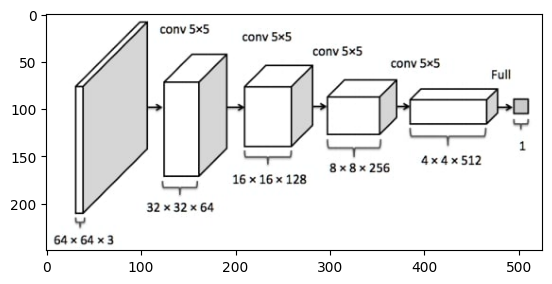

In [2]:
img = cv2.imread("dcgan-discriminator.jpg")
plt.imshow(img)

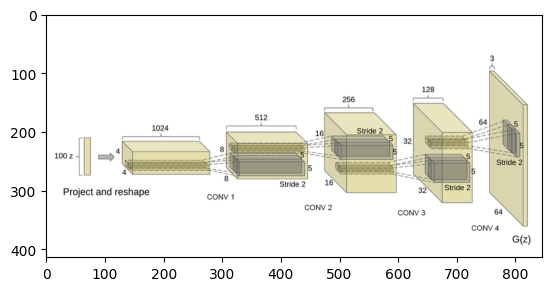

In [3]:
img = cv2.imread("dcgans.png")
plt.imshow(img,cmap='Blues')

In [4]:
class Discriminator(nn.Module):
    def __init__(self, input_channels, img_channels):
        super().__init__()
        self.disc = nn.Sequential(
            self.block(input_channels, img_channels, 4, 2, 1),
            self.block(img_channels, img_channels * 2, 4, 2, 1),
            self.block(img_channels * 2, img_channels * 4, 4, 2, 1),
            self.block(img_channels * 4, img_channels * 8, 4, 2, 1),
            nn.Conv2d(img_channels * 8, 1, 4, 2, 0),
            nn.Sigmoid()
        )

    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, latent_dim, input_channels, img_channels):
        super().__init__()
        self.gen = nn.Sequential(
            self.block(latent_dim, img_channels * 16, 4, 1, 0),
            self.block(img_channels * 16, img_channels * 8, 4, 2, 1),
            self.block(img_channels * 8, img_channels * 4, 4, 2, 1),
            self.block(img_channels * 4, img_channels * 2, 4, 2, 1),
            nn.ConvTranspose2d(img_channels * 2, input_channels, 4, 2, 1),
            nn.Tanh(),
        )

    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.gen(x)


In [5]:

class DCGAN():
    def __init__(self, latent_dim, input_channels, img_channels, batch_size):
        self.discriminator = Discriminator(input_channels, img_channels)
        self.generator = Generator(latent_dim, input_channels, img_channels)
        self.latent_dim = latent_dim
        self.input_channels = input_channels
        self.img_channels = img_channels
        self.batch_size = batch_size

        self.device = torch.device("cuda")
        self.discriminator.to(self.device)
        self.generator.to(self.device)

    def train(self, x_train, k_steps=2, lr=3e-4, max_epochs=20):
        optim_discriminator = optim.Adam(self.discriminator.parameters(), lr=lr)
        optim_generator = optim.Adam(self.generator.parameters(), lr=lr)
        criterion = nn.BCELoss()
        error_discriminator = []
        error_generator = []

        for epoch in range(max_epochs):
            sum1 = torch.tensor([0.0], device=self.device)
            sum2 = torch.tensor([0.0], device=self.device)
            for batch_idx, (img_data, labels) in enumerate(x_train):
                img_data = img_data.to(self.device)
                labels = labels.to(self.device)
                random_noise = torch.randn(self.batch_size, self.latent_dim, 1, 1, device=self.device)

                temp1 = torch.tensor([0.0], device=self.device)
                for k in range(k_steps):
                    self.discriminator.zero_grad()
                    D_x = self.discriminator(img_data)
                    D_G_x = self.discriminator(self.generator(random_noise))

                    D_x_flatten = D_x.reshape(-1)
                    D_G_x_flatten = D_G_x.reshape(-1)

                    loss_discriminator = criterion(D_x_flatten, torch.ones_like(D_x_flatten)) + criterion(
                        D_G_x_flatten, torch.zeros_like(D_G_x_flatten))
                    temp1 = loss_discriminator

                    loss_discriminator.backward()
                    optim_discriminator.step()

                sum1 += temp1 * self.batch_size

                random_noise = torch.randn(self.batch_size, self.latent_dim, 1, 1, device=self.device)
                self.generator.zero_grad()
                D_G_x = self.discriminator(self.generator(random_noise))
                D_G_x_flatten = D_G_x.reshape(-1)

                loss_generator = criterion(D_G_x_flatten, torch.ones_like(D_G_x_flatten))
                sum2 += loss_generator * self.batch_size

                loss_generator.backward()
                optim_generator.step()

            sum1 = sum1 / len(x_train.dataset)
            sum2 = sum2 / len(x_train.dataset)
            error_discriminator.append(sum1.item())
            error_generator.append(sum2.item())

        print(f"The error of the discriminator: {error_discriminator[-1]}, and for the generator: {error_generator[-1]}")
        epochs = range(1, max_epochs + 1)
        plt.plot(epochs, error_discriminator, label='Discriminator Loss')
        plt.plot(epochs, error_generator, label='Generator Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Generator and Discriminator Loss')
        plt.legend()
        plt.show()

    def sample(self):
        random_noise = torch.randn(1, self.latent_dim, 1, 1, device=self.device)
        image = self.generator(random_noise)
        D_G_x = self.discriminator(image)
        return image, D_G_x


<p>The program provided is an implementation of a DCGAN (Deep Convolutional Generative Adversarial Network) in Python using the PyTorch library. It defines a class called DCGAN that encapsulates the functionality of the generator and discriminator networks, as well as the training and sampling processes.</p>

Here's a breakdown of the program:

* Class Initialization:
 * The DCGAN class is initialized with parameters such as latent_dim (dimensionality of the input noise vector), input_channels (number of input channels for the discriminator), img_channels (number of channels in the generated images), and batch_size.
 * The discriminator and generator networks are created and stored as attributes of the class.
 * The device (CPU or GPU) is set to run the computations.
 
* Training Method:
 * The train method takes a x_train dataset, which is expected to provide image data and labels in batches.
 * The method sets up the optimizers, loss criterion, and variables to track the errors of the discriminator and generator during training.
 * The training loop runs for the specified number of epochs and iterates over the batches of the x_train dataset.
 * For each batch, the discriminator and generator are trained in an alternating manner using the given number of k_steps.
 * The loss values are calculated, gradients are backpropagated, and the optimizer's step function is called for both networks.
 * The average errors for the discriminator and generator are computed and stored for each epoch.
 * Finally, the errors are printed, and a plot showing the discriminator and generator loss over epochs is displayed.
 
* Sampling Method:
 * The sample method generates a single image by sampling random noise from a normal distribution and passing it through the generator network.
 * The generated image is then passed through the discriminator network, and both the image and the discriminator output are returned.

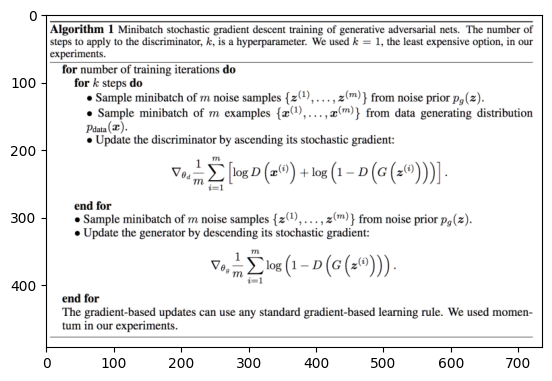

In [3]:
img = cv2.imread("gan.png")
plt.imshow(img)

The error of the discriminator: 0.022258911281824112, and for the generator: 7.748816013336182


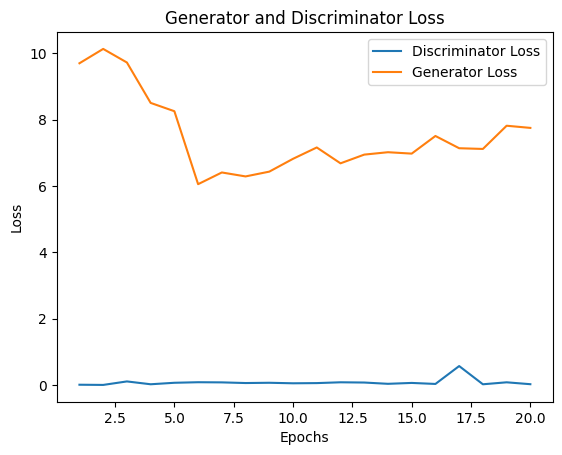

In [6]:
input_size = 64
input_channels = 1
img_channels = 64
latent_dim = 100
batch_size = 128

transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * input_channels, [0.5] * input_channels),
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
x_train = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

model = DCGAN(latent_dim, input_channels, img_channels, batch_size)
model.train(x_train)


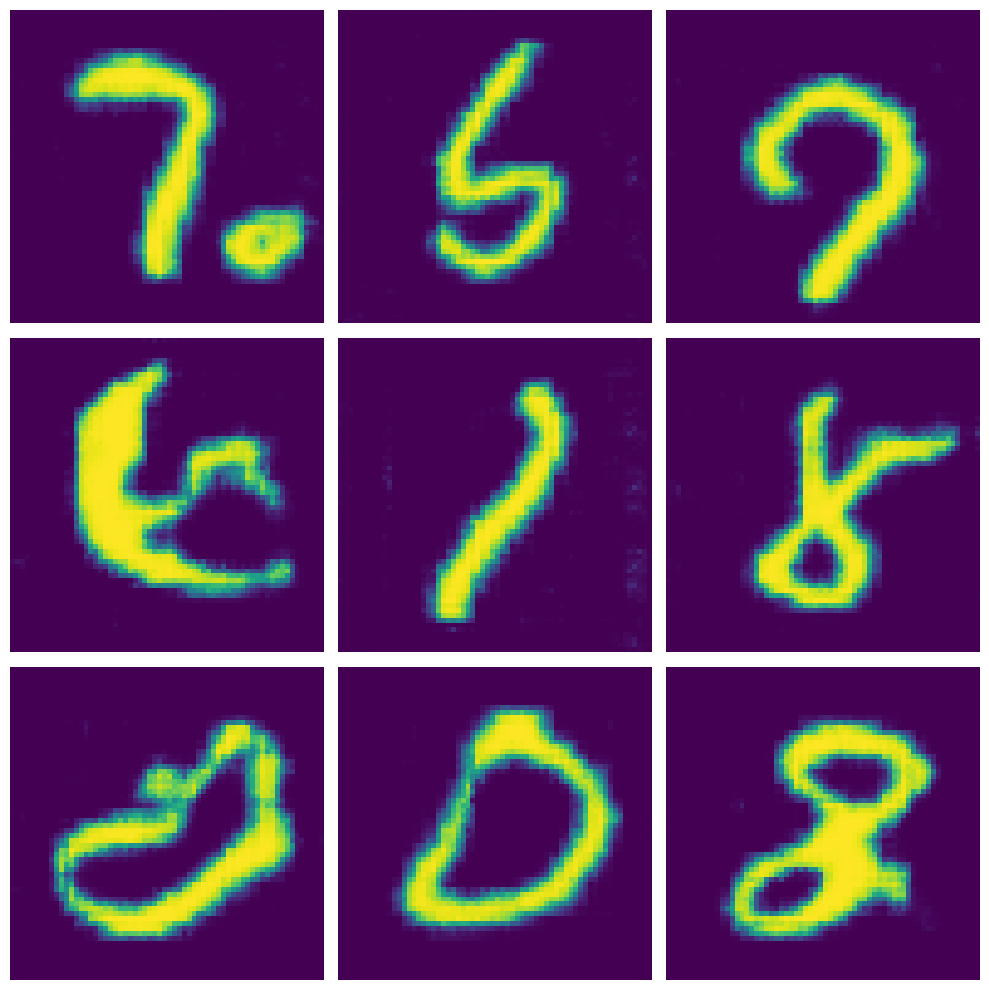

In [12]:
# Set the number of rows and columns for the grid
rows = 3
cols = 3

# Create a figure and axis objects for the grid
fig, axs = plt.subplots(rows, cols, figsize=(10, 10))

# Generate and plot images
for i in range(rows):
    for j in range(cols):
        img, _ = model.sample()
        img = img.cpu().detach().squeeze().numpy()
        img = img.reshape(64, 64)
        axs[i, j].imshow(img)
        axs[i, j].axis('off')

# Display the grid of images
plt.tight_layout()
plt.show()

<h3>Advantages of DCGAN:</h3>

 * Stable Training: DCGAN introduced architectural guidelines and training techniques that promote stable and effective training of generative models.
 * High-Quality Image Generation: DCGANs have shown impressive results in generating high-quality, realistic images across different domains, such as faces, bedrooms, and handwritten digits.
 * Disentangled Representations: DCGANs can learn meaningful and disentangled representations of the underlying data, allowing for manipulation and exploration of specific image features.
 * Wide Applicability: DCGANs have been successfully applied to various tasks, including image generation, image-to-image translation, and unsupervised representation learning.